<a href="https://colab.research.google.com/github/Bot1719744/Tumor-Classifier/blob/VGG-19/VGG_19_train_accuracy_95_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notice: This code is intended solely for internal educational use as part of a student project. Please respect its non-commercial nature and refrain from sharing it outside the project team.

# Environment Setup

*   Import packages





In [1]:
# !pip install imutils

In [2]:
# Import packages

# operating system
import os
# image processing
import cv2
import imutils
# numerical computations
import numpy as np
# data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# VGG19 preprocessing and model
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
# image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# neural networks building
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
# callback functions for model training
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

# Data Import

*   Import dataset from Google Drive.
*   Split dataset into train, validation, and test sets.
*   Label data as yes/no.
*   Plot some data to get a general impression.







In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define path to the dataset
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset/'

# Make a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):

         all_images.append(os.path.join(folder_path, filename))

# Make a list of numerical labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of 3 sets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


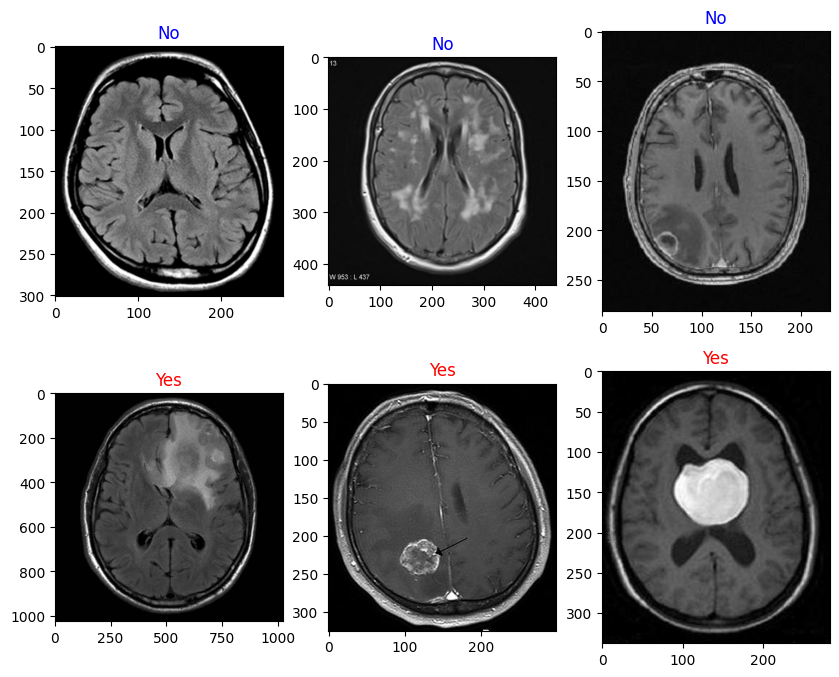

In [5]:
%matplotlib inline

# Add the yes/no labels to the image
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for both yes/no labels
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

# Data Preprocessing


*   Preprocessing steps: resizing, converting to grayscale, applying Gaussian blur, thresholding, contour detection, and cropping.
*   Apply the steps to train, validation, and test sets.
*   Convert the subsets to NumPy arrays.
*   Plot some preprocessed images to get a clearer impression.





In [6]:
def preprocess_images(images):
    preprocessed_images = []
    # loop through all the images
    for i, img_path in enumerate(images):
      # load image and resize to a standard size
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        # convert image to greyscale and apply Gaussian blur to enhance features
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # use thresholding and morphological operations to create binary images and remove noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # detect contours to identify the main object
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # identify the extreme points to define a tight bounding box
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop the image based on the bounding box, focusing augmentation efforts on the main object
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        # append the processed image to the list
        preprocessed_images.append(new_img)
    # conver the list to a NumPy array
    return np.array(preprocessed_images)

In [7]:
# Apply the data preprocessing to all 3 subsets
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [8]:
# Convert the subsets to NumPy arrays
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

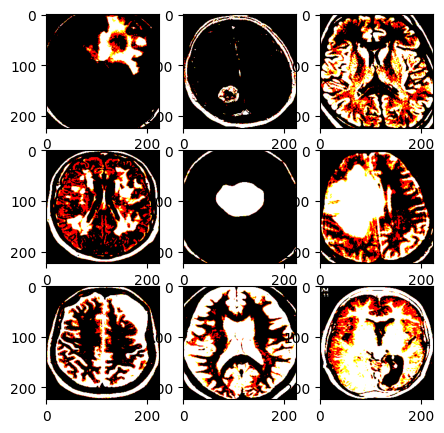

In [9]:
# Plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

# Model Training (VGG-19)

*   Model Setup:
     Load the pre-trained VGG-19 model, create a new sequential model, freeze base model weights, and compile the model.

*   Data Augmentation:
     Specify techniques incl. rescaling, rotation, width and height shifting, shearing, zooming, horizontal flipping, and fill mode. Flow the training set through these techniques.

*   Callbacks:
     One callback to reduce the learning rate dynamically when validation accuracy plateaus. Another to stop training when validation accuracy reaches 90%.

*   Validation Data Generator:
     Rescale the pixel values for the validation set to ensure validity.

*   Model Training:
     Fit the model with the augmented training set, validation set and callbacks.

In [10]:
### MODEL SETUP ###

# Load the pre-trained VGG19 model
base_model = VGG19(
weights='imagenet',
include_top=False,
input_shape=(224,224) + (3,)
)

# Create a new sequential model by adding layers on top of the pre-trained model
model = Sequential()
model.add(base_model)  # Add the pre-trained VGG19 model
model.add(Flatten())  # Flatten the output to a vector
model.add(Dropout(0.5))  # Add a dropout layer for regularization
model.add(Dense(1, activation='sigmoid'))  # Add a dense layer for binary classification

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the model summary
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [11]:
### DATA AUGMENTATION ###

# Define data augmentation techniques
train_datagen = ImageDataGenerator(
rescale=1./255,  # rescale pixel values to [0, 1]
rotation_range=20,  # randomly rotate images within 20 degrees
width_shift_range=0.1,  # randomly shift images horizontally
height_shift_range=0.1,  # randomly shift images vertically
shear_range=0.2,  # shear transformations
zoom_range=0.2,  # zooming transformations
horizontal_flip=True,  # randomly flip images horizontally
fill_mode='nearest'  # strategy for filling in newly created pixels
)

# Create the training data generator by flowing training data through the defined techniques
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

In [12]:
### CALLBACKS ###

# Define a callback to reduce the learning rate dynamically when validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5)

# Define a custome callback to stop training when validation accuracy reaches 90%
class StopOnAccuracy(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy, stopping training...")
            self.model.stop_training = True

In [13]:
### VALIDATION DATA GENERATOR ###

# Define validation data preprocessing, only rescale pixel values
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator by flowing validation data through the defined preprocessing
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)

In [14]:
### MODEL TRAINING ###

# Train the model using the training data generator, validation data generator and the defined callbacks
history = model.fit(
train_generator,
epochs=35,
validation_data=val_generator,
callbacks=[reduce_lr,StopOnAccuracy()]
)

Epoch 1/35
6/6 [==============================] - 228s 40s/step - loss: 0.7910 - accuracy: 0.5628 - val_loss: 0.6398 - val_accuracy: 0.6129 - lr: 0.0010
Epoch 2/35
6/6 [==============================] - 220s 40s/step - loss: 0.6968 - accuracy: 0.6612 - val_loss: 0.5489 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 3/35
6/6 [==============================] - 212s 37s/step - loss: 0.6324 - accuracy: 0.6667 - val_loss: 0.5582 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 4/35
6/6 [==============================] - 211s 37s/step - loss: 0.5328 - accuracy: 0.7268 - val_loss: 0.4920 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 5/35
6/6 [==============================] - 210s 37s/step - loss: 0.5295 - accuracy: 0.7213 - val_loss: 0.4488 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 6/35
6/6 [==============================] - 170s 29s/step - loss: 0.4429 - accuracy: 0.7869 - val_loss: 0.4818 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 7/35
6/6 [==============================] - 169s 30s/step - loss: 0.5109 - a

# Model Evaluation

*   Plot the accuracy curves for training & validation sets.
*   Plot the loss curves for training & validation sets.
*   Plot confusion matrix.
*   Calculate test accuracy.

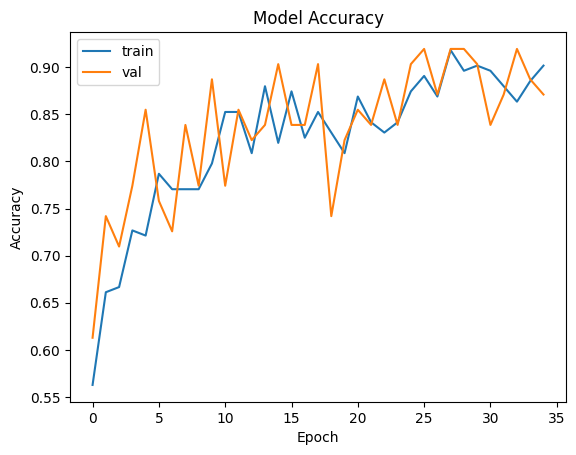

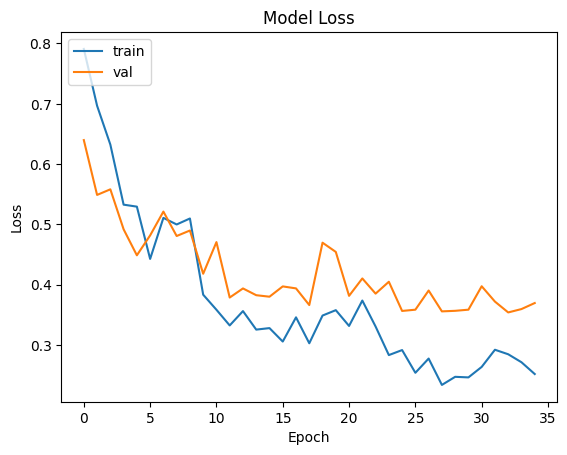

In [15]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 6s 6s/step


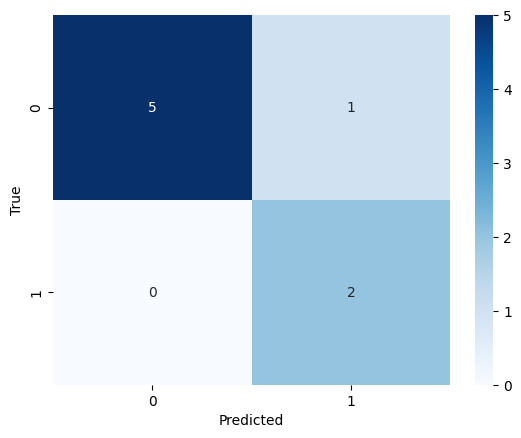

Test Accuracy: 0.875


In [16]:
# Predict on test set
y_pred = model.predict(X_test_pre)
y_pred = np.round(y_pred).astype(int)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', test_accuracy)